In [1]:
# make the notebook more readable:
import warnings; warnings.filterwarnings('ignore')

# a sound alarm to notify me, a cell has finished. i get distracted.
# https://gist.github.com/tamsanh/a658c1b29b8cba7d782a8b3aed685a24
from IPython.lib.display import Audio
import numpy as np

def beep(fr=4410, sec=1.0/7):
    t = np.linspace(0, sec*2, int(fr*sec))
    audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
    return Audio(audio_data, rate=4410, autoplay=True)

# EIS and LCC

Somebody once asked me for a timeseries with cloud data, that has a confirmed causal relationship. I had no answer. Today I read this in a paper about emergent constraints (Klein and Hall, 2015):

> There is ample observational evidence for an association between *low cloud cover* (LCC) and *estimated inversion strength* (EIS) (Wood and Bretherton, 2006), including evidence that the direction of causation is primarily from EIS to LCC (Klein et al., 1995), rather than the reverse. Furthermore, the physical mechanism by which EIS influences LCC is clear: Stronger inversions inhibit the mixing of dry free-tropospheric air into the boundary layer, keeping boundary layer relative humidity and thus LCC higher.

## EUREC4A

The EUREC4A LES Simulations seem a good source of model output for this purpose:

In [2]:
import eurec4a
import xarray as xr
import numpy as np

def eureca_3D_data():
    return eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control['3D_DOM01'].to_dask()

def eureca_3D_data_reduced():
    data = eureca_3D_data()
    data = data.drop_vars(['cloud_num','height_bnds','qc','qr','rho','theta_v','u','v','w'])
    return data

def random_eureca_profile(retrieval_function=eureca_3D_data_reduced):
    data_3d = retrieval_function()
    data_2d = data_3d.isel(time=np.random.randint(data_3d.time.shape), drop=True).mean(dim='time')
    data_1d = data_2d.isel(cell=np.random.randint(data_2d.cell.shape), drop=True).mean(dim='cell')
    return data_1d

def timestep_eureca_profile(i, retrieval_function=eureca_3D_data_reduced):
    data_3d = retrieval_function()
    data_2d = data_3d.isel(time=i, drop=True)
    data_1d = data_2d.isel(cell=np.random.randint(data_2d.cell.shape), drop=True).mean(dim='cell')
    return data_1d


# this is meant to make the data more interchangable, used to look up short names for variables.
VARDICT = {'pressure':'pres', 'temperature':'temp', 'specific humidity':'qv'}

profile = random_eureca_profile()
profile

<xarray.Dataset>
Dimensions:  (height: 68)
Coordinates:
  * height   (height) float64 83.0 84.0 85.0 86.0 ... 147.0 148.0 149.0 150.0
Data variables:
    pres     (height) float32 dask.array<chunksize=(4,), meta=np.ndarray>
    qv       (height) float32 dask.array<chunksize=(4,), meta=np.ndarray>
    temp     (height) float32 dask.array<chunksize=(4,), meta=np.ndarray>

## Estimated inversion strength (EIS)

This proxy is an improvement of another widely used proxy: *lower tropospheric stability* (LTS). It basically takes LTS and corrects it for the part of the profile that follows the lapse rate.

$$ EIS = LTS - \Gamma_m^{850} ( z_{700} - LCL) $$

with 

$$ LTS = \theta_{0} -  \theta_{700 hPa} $$

<!--
$$ z_{700} = (R_a T_0 / g) ln(p_0 / 700 hPa)$$
-->

### lower tropospheric stablity (LTS)

a rough estimate of stability using potential temperature ($\theta$) at two pressure levels.

In [3]:
from metpy.units import units
import metpy.calc as mpcalc

def nearest_value_index(array, value):
    # https://www.geeksforgeeks.org/find-the-nearest-value-and-the-index-of-numpy-array/
    difference_array = np.absolute(array-value)
    # index = difference_array.argmin()
    index = np.nanargmin(difference_array)
    return index

def lower_tropospheric_stability(dataset, names=VARDICT):
    p = dataset[names['pressure']].values
    t = dataset[names['temperature']].values
    i = nearest_value_index(p, 70000)
    theta_s   = mpcalc.potential_temperature(p[-1] * units('Pa'), t[-1] * units('kelvin'))
    theta_700 = mpcalc.potential_temperature(p[i] * units('Pa'), t[i] * units('kelvin'))
    return (theta_700 - theta_s).magnitude

lower_tropospheric_stability(profile)

15.494759975363422

### lifting condensation level ($LCL$)
The height at which a adiabatically lifted air parcel reaches saturation.

In [4]:
def lifting_condensation_level_pressure_and_temperature(dataset, names=VARDICT):
    pressure          = dataset[names['pressure']].values[-1] * units('Pa')
    temperature       = dataset[names['temperature']].values[-1]  * units('K')
    specific_humidity = dataset[names['specific humidity']].values[-1] 
    dewpoint = mpcalc.dewpoint_from_specific_humidity(pressure, temperature, specific_humidity)
    return mpcalc.lcl(pressure, temperature, dewpoint)

lifting_condensation_level_pressure_and_temperature(profile)

(array(95546.90509384) <Unit('pascal')>, 292.1396810683375 <Unit('kelvin')>)

We need an actual height, but there is no information about height in the data. A hydrostatic height approximation should be enough.

In [5]:
def hydrostatic_profile(h, p_surf=100000):
    # https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.add_height_to_pressure.html
    # This assumes a standard atmosphere [NOAA1976].
    # mpcalc.add_height_to_pressure(pressure, height)
    p = np.zeros(len(h))
    p[0] = p_surf
    for i in range(1,len(p)):
        pressure = p[i-1] * units('Pa')
        height   = (h[i] - h[i-1]) * units('m')
        calc = mpcalc.add_height_to_pressure(pressure, height).to(units('Pa'))
        p[i] = calc.magnitude
        if p[i] == np.nan: p[i] = 0.0
    return p

def nearest_value_index(array, value):
    # https://www.geeksforgeeks.org/find-the-nearest-value-and-the-index-of-numpy-array/
    difference_array = np.absolute(array-value)
    # index = difference_array.argmin()
    index = np.nanargmin(difference_array)
    return index

def pres2heigth(p, max_height=50000, meter_per_level=1):
    h = np.linspace(0,max_height, int(max_height/meter_per_level))
    p_ref = hydrostatic_profile(h, p[0])
    h = np.asarray([h[nearest_value_index(p_ref, value)] for value in p])
    return h

def add_hydrostatic_height(dataset, names=VARDICT):
    global VARDICT
    VARDICT['height'] = 'z'
    p = dataset[names['pressure']].values
    hydrostatic = np.flip(pres2heigth(np.flip(p)))
    dataset['z'] = hydrostatic
    return dataset

profile = add_hydrostatic_height(profile)
# this usually take around 40 seconds. this function has to be replaced eventually.

Now we just have to look up the matching model level to our LCL pressure.

In [6]:
def find_modellevel(value, dataset, name):
    array = dataset[name].values
    return nearest_value_index(array, value)

def find_height(value, dataset, name, names=VARDICT):
    i = find_modellevel(value, dataset, names['pressure'])
    return dataset[names['height']].values[i]

def lifting_condensation_level_height(dataset, names=VARDICT):
    lcl_p, lcl_t = lifting_condensation_level_pressure_and_temperature(dataset)
    return find_height(lcl_p.magnitude, dataset, names['pressure'])

lifting_condensation_level_height(profile)

523.0104602092041

### height of the 700 hPa pressure level ($z_{700}$)
This can also be found using the above function:

In [7]:
find_height(700*100, profile, 'pres')

3059.0611812236243

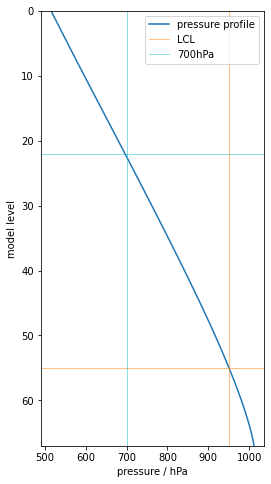

In [8]:
import matplotlib.pyplot as plt

profile_1 = random_eureca_profile()
lcl_p, lcl_t = lifting_condensation_level_pressure_and_temperature(profile_1)
p = profile_1['pres'].values
y = np.asarray(range(len(p)))

fig, ax = plt.subplots(figsize=(4,8))
ax.plot(p / 100,y, label='pressure profile')
ax.axhline(find_modellevel(lcl_p.magnitude, profile_1, 'pres'), label='LCL', color='tab:orange', lw=0.5)
ax.axhline(find_modellevel(700*100, profile_1, 'pres'),        label='700hPa', color='tab:cyan', lw=0.5)
ax.axvline(700, color='tab:cyan', lw=0.5)
ax.axvline(lcl_p.magnitude / 100, color='tab:orange', lw=0.5)
ax.set_ylabel('model level')
ax.set_xlabel('pressure / hPa')
ax.set_ylim(len(p)-1,0)
ax.legend()
plt.show()

### A faster pressure to height conversion

While the lookup is fast, providing them via the above method is very slow. Wood and Bretherton (2006) use a simplified formula based on the assumption, that pressure decreases logarithmically with height:

In [9]:
import metpy.constants as mpconst

def exp_pres2height(pressure_level, dataset, names=VARDICT): 
    p  = pressure_level * units('Pa')
    p0 = dataset[names['pressure']].values[-1] * units('Pa')
    T0 = dataset[names['temperature']].values[-1] * units('K')
    Ra = mpconst.dry_air_gas_constant
    g  = mpconst.earth_gravity
    return ((Ra * T0 / g) * np.log(p0 / p) ).magnitude

We could also try to get height information from the initial field, which provides *half level heights*.

In [10]:
import xarray as xr
import numpy as np

def initc_half_level_heigths(path='/work/mh1126/m300872/unchanged/initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc'):
    return xr.open_dataset(path)['z_ifc'].mean(dim=['ncells','time']).values

def interpolate_full_level(half_level):
    return np.asarray([np.round((half_level[i]+half_level[i-1])/2,0) for i in range(1,len(half_level))])

def initc_full_level_heights():
    return interpolate_full_level(initc_half_level_heigths())

In [11]:
x = random_eureca_profile()
p = x['pres'].values
x['z_pres'] = np.flip(pres2heigth(np.flip(p)))
x['z_full'] = initc_full_level_heights()[-len(p)::]

pressure_levels = [50000, 70000, 85000, 90000, 100000]
print('lvl    exp   hydros  initc')
for i in [find_modellevel(pl, x, 'pres') for pl in pressure_levels]:
    print(f'{i}'.rjust(3), 
          f'{exp_pres2height(x["pres"].values[i], x):.0f}'.rjust(6), 
          f'{x["z_pres"].values[i]:.0f}'.rjust(8), 
          f'{x["z_full"].values[i]:.0f}'.rjust(6))

lvl    exp   hydros  initc
  0   5917     5349  25016
 22   3278     3049  10677
 41   1527     1447   3990
 47   1071     1020   2570
 63    133      128    218


The exponential assumption is much faster and yields acceptable results. The interpolated levels from the initial conditions are fast, too but the produced heights seem far off.

We will have a closer look at the effect on overall EIS later in the notebook.

### lapse rate at 850 hPa ($\Gamma_m^{850}$)

Wood and Bretherton (2006) give the following formula:

$$ \Gamma_m (T,p) = \frac{g}{c_p} \Big[ 1 - \frac{1 + L_v q_s (T,p) / R_a T}{1 + L^2_v q_s (T,p) / c_p R_v T^2} \Big]$$
where
* $L_v$ is the latent heat of vaporization, 
* $q_s$ is the saturation mixing ratio, 
* $R_a$ and $R_v$ are the gas constants for dry air and water vapor, respectively
* $g$ is the gravitational acceleration, and 
* $c_p$ is the specific heat of air at constant pressure. 

In [12]:
import metpy.constants as mpconst

def gamma_m(temperature, pressure):
    T = temperature * units('K')
    p = pressure    * units('Pa')
    Lv = mpconst.water_heat_vaporization
    qs = mpcalc.saturation_mixing_ratio(p, T)
    g  = mpconst.earth_gravity
    Rv = mpconst.water_gas_constant
    Ra = mpconst.dry_air_gas_constant 
    cp = mpconst.dry_air_spec_heat_press
    upper = 1 + (Lv * qs) / (Ra * T)
    lower = 1 + (Lv**2 * qs) / (cp * Rv * T**2)
    return (g / cp) * (1 - (upper/lower))

def potential_temperature_gradient_at_pressure_level(dataset, pressure_level, names=VARDICT):
    i = find_modellevel(pressure_level, dataset, names['pressure'])
    pressure    = dataset[names['pressure']].values[i]
    temperature = dataset[names['temperature']].values[i]
    return gamma_m(temperature, pressure).magnitude

potential_temperature_gradient_at_pressure_level(profile, 850*100, names=VARDICT)

0.005210462109819533

Unit is given as `kelvin kilogram meter/(joule second2)`. With joule being $kg \cdot m^2 \cdot s^{−2}$ this matches the expected $K/m$.

We potentially have potential temperatures for the whole profile. It should be possible to calculate the lapse rate as a gradient between two points.

In [13]:
def potential_temperature_gradient_at_height_interval(dataset, interval, names=VARDICT):
    h = dataset[names['height']].values
    t = dataset[names['temperature']].values
    p = dataset[names['pressure']].values
    lo, hi = [nearest_value_index(h,i) for i in interval]
    if hi == lo: raise ValueError('interval too small. lower boundary == upper boundary.')
    theta = mpcalc.potential_temperature(p * units('Pa'), t * units('K')).magnitude
    return (theta[hi] - theta[lo]) / (h[hi] - h[lo])

potential_temperature_gradient_at_height_interval(profile, (0,5000))

0.004346532388269818

In [14]:
VARDICT['potential temperature'] = 'theta_v'

def potential_temperature_gradient_at_pressure_interval(dataset, interval, names=VARDICT):
    h = dataset[names['height']].values
    t = dataset[names['temperature']].values
    p = dataset[names['pressure']].values
    # there seems to be no difference between reading theta from disk and calculating it. neither in value nor in speed
    theta = mpcalc.potential_temperature(p * units('Pa'), t * units('K')).magnitude
    lo, hi = [nearest_value_index(p,i) for i in interval]
    if hi == lo: raise ValueError('interval too small. lower boundary == upper boundary.')
    return (theta[hi] - theta[lo]) / (h[hi] - h[lo])

potential_temperature_gradient_at_pressure_interval(profile, (840*100, 860*100))

0.004288579187983962

This does look questionable. We will stick with the Wood and Bretherton (2006) solution.

In [15]:
profile_1 = add_hydrostatic_height(random_eureca_profile(eureca_3D_data))
gamma = potential_temperature_gradient_at_pressure_level(profile_1, 850*100, names=VARDICT)
theta = profile_1['theta_v'].values
heights = profile_1['z'].values

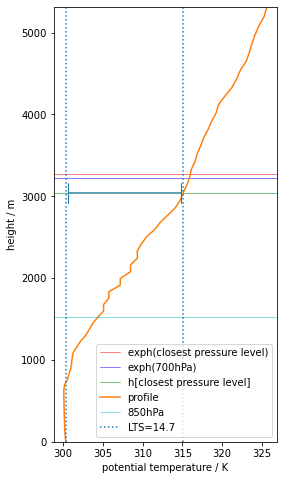

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4,8))
y1, y2 = len(heights)-1, find_modellevel(700*100, profile_1, 'pres')
x1, x2 = theta[y1], theta[y2]

ax.axhline(exp_pres2height(profile_1['pres'].values[y2], profile_1), 
           color='red', lw=0.5, label='exph(closest pressure level)')
ax.axhline(exp_pres2height(70000, profile_1),
           color='blue', lw=0.5, label='exph(700hPa)')
ax.axhline(profile_1['z'].values[y2],
           color='green', lw=0.5, label='h[closest pressure level]')
ax.plot(theta, heights, label='profile', color='tab:orange')

ax.axhline(exp_pres2height(850*100, profile_1), label='850hPa', color='tab:cyan', lw=0.5)
ax.axvline(x1, ls=':', label=f'LTS={x2-x1:.1f}')
ax.axvline(x2, ls=':')
plt.annotate('', xy=(x1,heights[y2]), xycoords='data', 
             xytext=(x2,heights[y2]), textcoords='data', 
             arrowprops={'arrowstyle': '|-|', 'color': 'tab:blue'})
ax.set_ylabel('height / m')
ax.set_xlabel('potential temperature / K')
ax.set_ylim(heights[-1], heights[0])
ax.legend()
plt.show()

### Bringing it together

We found solutions for the involved components. Now we just have to bring them together.

$$ EIS = LTS - \Gamma_m^{850} ( z_{700} - LCL) $$

Since we have two methods to calculate heights, we can have two methods for EIS calculation. We would expect the fast version with the simplified hydrostatic height calculation to be less exact. 

In [17]:
def estimated_inversion_strength_slow(dataset, names=VARDICT):
    try:    test = dataset[names['height']]
    except: dataset = add_hydrostatic_height(dataset)
    lts = lower_tropospheric_stability(dataset)
    gamma = potential_temperature_gradient_at_pressure_level(dataset, 850 * 100)
    z700 = find_height(700 * 100, dataset, names['pressure'])
    lcl = lifting_condensation_level_height(dataset)
    return lts - gamma * (z700 - lcl)

def estimated_inversion_strength_fast(dataset, names=VARDICT):
    lts = lower_tropospheric_stability(dataset)
    gamma = potential_temperature_gradient_at_pressure_level(dataset, 850 * 100)
    lcl_p, lcl_t = lifting_condensation_level_pressure_and_temperature(dataset)
    lcl = exp_pres2height(lcl_p.magnitude, dataset)
    z700 = exp_pres2height(700*100, dataset)
    return lts - gamma * (z700 - lcl)

If we compare them to each other, there seems to be a systematic bias:

In [18]:
# commented out, takes 20min:

# diffs = list()
# for i in range(20):
#     profile = random_eureca_profile()
#     slow_eis = estimated_inversion_strength_slow(profile)
#     fast_eis = estimated_inversion_strength_fast(profile)
#     print(f'slow: {slow_eis:.2f}, fast: {fast_eis:.2f}, diff: {fast_eis-slow_eis:.2f}')
#     diffs.append(fast_eis-slow_eis)
# print()
# print('mean bias:',np.mean(diffs), 'standard deviation:', np.std(diffs))
# beep()

```slow: -0.36, fast: -1.65, diff: -1.29
slow: 5.59, fast: 4.70, diff: -0.89
slow: 3.96, fast: 3.21, diff: -0.75
slow: 1.14, fast: 0.40, diff: -0.74
slow: 2.82, fast: 2.01, diff: -0.82
slow: 0.29, fast: -0.53, diff: -0.82
slow: 0.73, fast: -0.12, diff: -0.85
slow: 4.34, fast: 3.41, diff: -0.93
slow: -0.12, fast: -1.27, diff: -1.15
slow: 1.65, fast: 0.69, diff: -0.96
slow: -0.14, fast: -1.09, diff: -0.96
slow: 0.36, fast: -0.56, diff: -0.92
slow: 2.44, fast: 1.51, diff: -0.93
slow: 0.08, fast: -0.69, diff: -0.76
slow: 2.11, fast: 0.96, diff: -1.15
slow: 1.50, fast: 0.70, diff: -0.80
slow: 1.14, fast: 0.34, diff: -0.80
slow: 4.18, fast: 3.36, diff: -0.81
slow: 0.46, fast: -0.56, diff: -1.02
slow: 3.51, fast: 2.71, diff: -0.80

mean bias: -0.9084038774733203 standard deviation: 0.14444142476278962
```

In [19]:
diffs = [-1.2867099190328215, -0.8903068734531097, -0.7505299213213057, -0.743291060629474, -0.8153713690062929, -0.8220589098847864, -0.8485805897411396, -0.9349641033458216, -1.1476805398288406, -0.9566612184804288, -0.955624199035789, -0.9245673911584493, -0.9335032226498026, -0.7642070017705969, -1.1549441691073525, -0.8032567767542336, -0.7994964682308545, -0.8128067194183668, -1.0233075016978042, -0.8002095949191386]

This bias could be corrected. At least it should be kept in mind.

In [20]:
def estimated_inversion_strength(profile):
    return estimated_inversion_strength_fast(profile)

## Creating a time series

We need 2D data, too. So we will only work on timesteps that are in both datasets.

In [21]:
import eurec4a
import xarray as xr

def eureca_3D_data():
    return eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control['3D_DOM01'].to_dask()

def eureca_3D_data_reduced(drop_vars=['cloud_num','height_bnds','qc','qr','rho','theta_v','u','v','w']):
    data = eureca_3D_data()
    data = data.drop_vars(drop_vars)
    return data

def eureca_2D_data():
    return eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control['surface_DOM01'].to_dask()


def eureca_2D_data_reduced(drop_vars=['lhfl_s', 'pres_sfc', 'qv_2m', 'rain_gsp_rate', 'rh_2m', 'shfl_s', 
                                      't_2m', 'tot_prec', 'tqc_dia', 'tqi_dia', 'tqv_dia', 'u_10m', 'v_10m']):
    data = eureca_2D_data()
    data = data.drop_vars(drop_vars)
    return data

In [22]:
def overlap_timesteps(a,b):
    timesteps_a = a.time.values
    timesteps_b = b.time.values
    return [timestep for timestep in timesteps_a if timestep in timesteps_b]

timesteps = overlap_timesteps(eureca_2D_data_reduced(), eureca_3D_data_reduced())
len(timesteps)

328

In [23]:
import random

data_3D = eureca_3D_data_reduced()
data_2D = eureca_2D_data_reduced()

def create_datapoint(timestep):
    global data_2D, data_3d
    profile = data_3D.sel(time=t).mean(dim='cell')
    lts = lower_tropospheric_stability(profile)
    clct = data_2D['clct'].sel(time=t).mean(dim='cell').values
    sst = data_2D['t_seasfc'].sel(time=t).mean(dim='cell').values
    eis = estimated_inversion_strength_fast(profile)
    return {'t': timestep, 'sst': sst, 'clct': clct, 'lts':lts, 'eis':eis}

data_EIS = {'t': list(), 'sst': list(), 'clct': list(), 'lts':list(), 'eis':list()}
for t in timesteps[0:3]:
    t = random.choice(timesteps)
    # d = create_datapoint(t)
    # for col in list(d): data_EIS[col].append(d[col])

In [24]:
import pandas as pd
pd.DataFrame.from_dict(data_EIS).to_csv('/home/m/m300872/test.csv')

In [25]:
def script_body(start,end):
    return f'''import eurec4a
import xarray as xr
import pandas as pd
import numpy  as np
from   metpy.units import units
import metpy.calc      as mpcalc
import metpy.constants as mpconst

VARDICT = {{'pressure':'pres', 'temperature':'temp', 'specific humidity':'qv'}}

def eureca_3D_data():
    return eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control['3D_DOM01'].to_dask()

def eureca_3D_data_reduced(drop_vars=['cloud_num','height_bnds','qc','qr','rho','theta_v','u','v','w']):
    data = eureca_3D_data()
    data = data.drop_vars(drop_vars)
    return data

def eureca_2D_data():
    return eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control['surface_DOM01'].to_dask()

def eureca_2D_data_reduced(drop_vars=['lhfl_s', 'pres_sfc', 'qv_2m', 'rain_gsp_rate', 'rh_2m', 'shfl_s', 
                                      't_2m', 'tot_prec', 'tqc_dia', 'tqi_dia', 'tqv_dia', 'u_10m', 'v_10m']):
    data = eureca_2D_data()
    data = data.drop_vars(drop_vars)
    return data

def overlap_timesteps(a,b):
    timesteps_a = a.time.values
    timesteps_b = b.time.values
    return [timestep for timestep in timesteps_a if timestep in timesteps_b]

def estimated_inversion_strength(dataset, names=VARDICT):
    lts = lower_tropospheric_stability(dataset)
    gamma = potential_temperature_gradient_at_pressure_level(dataset, 850 * 100)
    lcl_p, lcl_t = lifting_condensation_level_pressure_and_temperature(dataset)
    lcl = exp_pres2height(lcl_p.magnitude, dataset)
    z700 = exp_pres2height(700*100, dataset)
    return lts - gamma * (z700 - lcl)

def nearest_value_index(array, value):
    # https://www.geeksforgeeks.org/find-the-nearest-value-and-the-index-of-numpy-array/
    difference_array = np.absolute(array-value)
    # index = difference_array.argmin()
    index = np.nanargmin(difference_array)
    return index

def lower_tropospheric_stability(dataset, names=VARDICT):
    p = dataset[names['pressure']].values
    t = dataset[names['temperature']].values
    i = nearest_value_index(p, 70000)
    theta_s   = mpcalc.potential_temperature(p[-1] * units('Pa'), t[-1] * units('kelvin'))
    theta_700 = mpcalc.potential_temperature(p[i] * units('Pa'), t[i] * units('kelvin'))
    return (theta_700 - theta_s).magnitude

def lifting_condensation_level_pressure_and_temperature(dataset, names=VARDICT):
    pressure          = dataset[names['pressure']].values[-1] * units('Pa')
    temperature       = dataset[names['temperature']].values[-1]  * units('K')
    specific_humidity = dataset[names['specific humidity']].values[-1] 
    dewpoint = mpcalc.dewpoint_from_specific_humidity(pressure, temperature, specific_humidity)
    return mpcalc.lcl(pressure, temperature, dewpoint)

def nearest_value_index(array, value):
    # https://www.geeksforgeeks.org/find-the-nearest-value-and-the-index-of-numpy-array/
    difference_array = np.absolute(array-value)
    # index = difference_array.argmin()
    index = np.nanargmin(difference_array)
    return index

def find_modellevel(value, dataset, name):
    array = dataset[name].values
    return nearest_value_index(array, value)

def find_height(value, dataset, name, names=VARDICT):
    i = find_modellevel(value, dataset, names['pressure'])
    return dataset[names['height']].values[i]

def lifting_condensation_level_height(dataset, names=VARDICT):
    lcl_p, lcl_t = lifting_condensation_level_pressure_and_temperature(dataset)
    return find_height(lcl_p.magnitude, dataset, names['pressure'])

def exp_pres2height(pressure_level, dataset, names=VARDICT): 
    p  = pressure_level * units('Pa')
    p0 = dataset[names['pressure']].values[-1] * units('Pa')
    T0 = dataset[names['temperature']].values[-1] * units('K')
    Ra = mpconst.dry_air_gas_constant
    g  = mpconst.earth_gravity
    return ((Ra * T0 / g) * np.log(p0 / p) ).magnitude

def gamma_m(temperature, pressure):
    T = temperature * units('K')
    p = pressure    * units('Pa')
    Lv = mpconst.water_heat_vaporization
    qs = mpcalc.saturation_mixing_ratio(p, T)
    g  = mpconst.earth_gravity
    Rv = mpconst.water_gas_constant
    Ra = mpconst.dry_air_gas_constant 
    cp = mpconst.dry_air_spec_heat_press
    upper = 1 + (Lv * qs) / (Ra * T)
    lower = 1 + (Lv**2 * qs) / (cp * Rv * T**2)
    return (g / cp) * (1 - (upper/lower))

def potential_temperature_gradient_at_pressure_level(dataset, pressure_level, names=VARDICT):
    i = find_modellevel(pressure_level, dataset, names['pressure'])
    pressure    = dataset[names['pressure']].values[i]
    temperature = dataset[names['temperature']].values[i]
    return gamma_m(temperature, pressure).magnitude

if __name__ == '__main__':
    data_3D = eureca_3D_data_reduced()
    data_2D = eureca_2D_data_reduced()
    
    def create_datapoint(timestep):
        global data_2D, data_3d
        profile = data_3D.sel(time=t).mean(dim='cell')
        lts = lower_tropospheric_stability(profile)
        clct = data_2D['clct'].sel(time=t).mean(dim='cell').values
        sst = data_2D['t_seasfc'].sel(time=t).mean(dim='cell').values
        eis = estimated_inversion_strength(profile)
        return {{'t': timestep, 'sst': sst, 'clct': clct, 'lts':lts, 'eis':eis}}
    
    timesteps = overlap_timesteps(data_2D, data_3D)
    data_EIS = {{'t': list(), 'sst': list(), 'clct': list(), 'lts':list(), 'eis':list()}}
    
    for t in timesteps[{start}:{end}]:
        print(t)
        d = create_datapoint(t)
        for col in list(d): data_EIS[col].append(d[col])

    pd.DataFrame.from_dict(data_EIS).to_csv('/home/m/m300872/EIStimeseries{start}-{end}.csv', index=False)
'''

def seconds2clockstring(s):
    hours, remainder = divmod(s, 3600)
    minutes, seconds = divmod(remainder, 60)
    return '{:02}:{:02}:{:02}'.format(int(hours), int(minutes), int(seconds))

def minutes2clockstring(m):
    s = pd.Timedelta(m, 'm').total_seconds()
    return seconds2clockstring(s)

def slurm_header(minutes):
    return f'''#!/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/bin/python
#SBATCH --partition=compute
#SBATCH --account=mh0926
#SBATCH --nodes=1
#SBATCH --time={minutes2clockstring(minutes)}
#SBATCH --mail-type=fail
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=/home/m/m300872/log/%j_%x.log

'''

def generate_script(start, end):
    filename = f'/home/m/m300872/generateEIStimeseries{start}-{end}.py'
    with open(filename, 'w') as f:
        script = slurm_header(20) + script_body(start, end)
        f.writelines(script)
    return filename

In [26]:
import subprocess

n_scripts = 160
scripts = list()
for i in np.array_split(list(range(len(timesteps))), n_scripts):
    start, end = i[0], i[-1]
    if not start == 0: start += -1
    scripts.append(generate_script(start, end))
    
# # scripts=scripts[-2::]
# for s in scripts:
#     print(s, end=' : ')
#     subprocess.call(['sbatch', s])

In [73]:
import pandas as pd
import os
homedir = '/home/m/m300872/'
file_list = [os.path.join(homedir,f) for f in os.listdir(homedir) if 'EIStimeseries' in f and f.endswith('.csv')]
d = pd.concat((pd.read_csv(f) for f in file_list)).sort_values('t')
print(len(d), len(d.drop_duplicates()))
d = d.reset_index(drop=True).dropna()
d

41 41


t        sst       clct        lts       eis Unnamed: 0
0   2020-01-09 12:00:00   299.8406  29.560139   12.13092 -1.782542          0
1   2020-01-09 18:00:00  299.84683  23.324953  12.239319 -2.062382          0
2   2020-01-13 21:00:00  299.77448  41.023926   12.58172 -2.032402          0
3   2020-01-14 00:00:00  299.77603  47.958935  12.711528 -1.983781          1
4   2020-01-14 03:00:00   299.7827  55.184006  12.981471 -1.759471          2
5   2020-01-14 06:00:00  299.78107  61.785004  12.896074 -1.549437          3
6   2020-01-17 00:00:00  299.69406   51.74623  14.680104 -0.407955          0
7   2020-01-17 03:00:00   299.6923  59.373398  14.755907 -0.366494          1
8   2020-01-17 06:00:00  299.68723   65.60968  14.727161 -0.404801          2
9   2020-01-17 09:00:00   299.6849    58.7824  14.744062 -0.433799          3
12  2020-01-26 12:00:00   299.4903   78.55946  13.933285 -1.211433          0
13  2020-01-26 15:00:00  299.61087  79.425545   13.86807 -1.355568          1
14  2020-01-26 18:00:00   299.6289  79.061356  13.888685 -1.349601          2
15  2020-01-26 21:00:00  299.48553   78.02501  13.973883 -1.371103          3
16  2020-01-27 00:00:00  299.49033   70.47063  14.123744 -1.410299          4
17  2020-01-27 03:00:00   299.4996   72.29871  14.181135 -1.408107          5
18  2020-01-27 06:00:00  299.49722   77.68344  14.049995 -1.488593          6
19  2020-01-27 09:00:00   299.4938   78.32353  14.001104 -1.507205          7
21  2020-01-27 12:00:00   299.5355   69.08054  14.161663 -1.410238          8
23  2020-01-27 15:00:00   299.6888   64.42994  14.378705 -1.193809          9
24  2020-01-27 18:00:00   299.6887  62.616646  14.521302 -0.976193         10
25  2020-01-27 21:00:00  299.53116  61.579605  14.600889 -0.973772         11
26  2020-01-28 00:00:00   299.5504   58.81868  14.812262 -0.908438         12
27  2020-01-28 03:00:00  299.56042  58.149326  15.105263 -0.625657         13
28  2020-01-28 06:00:00  299.56082   59.00278  15.350317 -0.278338         14
37  2020-02-18 21:00:00   299.0419  40.480503  15.172245  0.702854          0
38  2020-02-19 00:00:00  299.04727  38.619232  15.320248  1.028419          1
39  2020-02-19 03:00:00   299.0419  38.320297  15.642457  1.439199          0

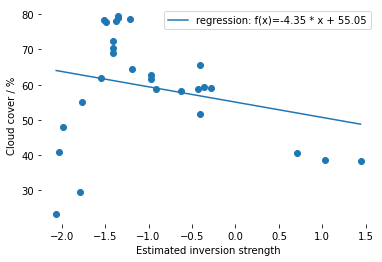

In [86]:
import matplotlib.pyplot as plt
import plot_utils as pu

def estimate_coef(x, y):
    # number of observations/points
    n = np.size(x)
    # mean of x and y vector
    m_x = np.mean(x)
    m_y = np.mean(y)
    # calculating cross-deviation and deviation about x
    SS_xy = np.sum(y*x) - n*m_y*m_x
    SS_xx = np.sum(x*x) - n*m_x*m_x
    # calculating regression coefficients
    b_0 = SS_xy / SS_xx
    b_1 = m_y - b_0*m_x
    return (b_0, b_1)

v1, v2 = 'eis', 'lts' # good, of course
v1, v2 = 'eis', 'clct'
x, y = d[v1], d[v2]


fig, ax = plt.subplots()
ax.scatter(x,y)
ax.set_xlabel('Estimated inversion strength')
ax.set_ylabel('Cloud cover / %')
pu.remove_spines(ax)

m, n = estimate_coef(x,y)
x_reg = np.linspace(np.min(x), np.max(x), 10)
y_reg = x_reg * m + n
ax.plot(x_reg, y_reg, label=f'regression: f(x)={m:.2f} * x + {n:.2f}')
ax.legend()

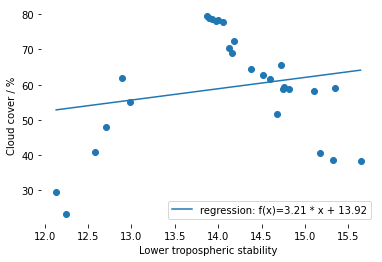

In [88]:
v1, v2 = 'lts', 'clct'
x, y = d[v1], d[v2]

fig, ax = plt.subplots()
ax.scatter(x,y)
ax.set_xlabel('Lower tropospheric stability')
ax.set_ylabel('Cloud cover / %')
pu.remove_spines(ax)

m, n = estimate_coef(x,y)
x_reg = np.linspace(np.min(x), np.max(x), 10)
y_reg = x_reg * m + n
ax.plot(x_reg, y_reg, label=f'regression: f(x)={m:.2f} * x + {n:.2f}')
ax.legend()

## Summary
The regressions for both LTS and EIS versus cloud cover are a bad fit. Removing data points with low EIS (e.g. below 0) could yield a dataset with higher correlation. It might be a good idea to look at regions that generally show a stronger inversion, for example stratocumulus regions like the subtrocial pacific coasts of the american continents.

## References:
    
* Klein, S. A., Hartmann, D. L., & Norris, J. R. (1995). On the relationships among low-cloud structure, sea surface temperature, and atmospheric circulation in the summertime northeast Pacific. *Journal of climate*, 8(5), 11, DOI:[10.1175/1520-0442(1995)008<1140:OTRALC>2.0.CO;2](https://doi.org/10.1175/1520-0442(1995)008<1140:OTRALC>2.0.CO;2)
* Klein, S. A., & Hall, A. (2015). Emergent constraints for cloud feedbacks. *Current climate change reports*, 1(4), 276-287., DOI:[10.1007/s40641-015-0027-1](https://link.springer.com/article/10.1007/s40641-015-0027-1)
* Wang, Z., Yuan, J., Wood, R., Chen, Y., & Tong, T. (2022). A Profile-based Estimated Inversion Strength. *Atmospheric Chemistry and Physics Discussions*, 1-22., DOI: [10.5194/acp-2022-731](https://doi.org/10.5194/acp-2022-731)
* Wood R, Bretherton CS. On the relationship between stratiform low cloud cover and lower-tropospheric stability. *J Climate*. 2006;19:6425–32. DOI:[10.1175/JCLI3988.1](https://doi.org/10.1175/JCLI3988.1) 